In [5]:
import multiprocessing
import time
import numpy as np
import scipy as sp
import emcee
import testkit
import ciamod
import os
import gc
import sys
import pickle
from scipy.io.idl import readsav
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.interpolate import InterpolatedUnivariateSpline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mgimg
import TPmod
import forwardmodel
from IPython.display import display
%matplotlib inline


In [6]:
# set up the model arguments the drop these into theta(state vector) or runargs
#set up pressure grids in bar cos its intuitive
logcoarsePress = np.arange(-4.0, 2.5, 0.53)
#logcoarsePress = np.arange(-4.0, 3.0, 0.5)
coarsePress = pow(10,logcoarsePress)
logfinePress = np.arange(-3.0, 3.0, 0.08)
finePress = pow(10,logfinePress)
# forward model wants pressure in bar
press = finePress
#nprof = coarsePress.size
#print nprof
print (finePress.size)
print (finePress)

75
[  1.00000000e-03   1.20226443e-03   1.44543977e-03   1.73780083e-03
   2.08929613e-03   2.51188643e-03   3.01995172e-03   3.63078055e-03
   4.36515832e-03   5.24807460e-03   6.30957344e-03   7.58577575e-03
   9.12010839e-03   1.09647820e-02   1.31825674e-02   1.58489319e-02
   1.90546072e-02   2.29086765e-02   2.75422870e-02   3.31131121e-02
   3.98107171e-02   4.78630092e-02   5.75439937e-02   6.91830971e-02
   8.31763771e-02   1.00000000e-01   1.20226443e-01   1.44543977e-01
   1.73780083e-01   2.08929613e-01   2.51188643e-01   3.01995172e-01
   3.63078055e-01   4.36515832e-01   5.24807460e-01   6.30957344e-01
   7.58577575e-01   9.12010839e-01   1.09647820e+00   1.31825674e+00
   1.58489319e+00   1.90546072e+00   2.29086765e+00   2.75422870e+00
   3.31131121e+00   3.98107171e+00   4.78630092e+00   5.75439937e+00
   6.91830971e+00   8.31763771e+00   1.00000000e+01   1.20226443e+01
   1.44543977e+01   1.73780083e+01   2.08929613e+01   2.51188643e+01
   3.01995172e+01   3.63078055e

In [7]:
w1 = 0.8
w2 = 2.4

dist = 11.35
# hardwired FWHM of data in microns
fwhm = 0.005

npatches = 1
nclouds = 1


do_clouds = np.array([0],dtype='i')


# CURRENTLY ONLY COPE WITH ONE CLOUDY PATCH.
#SO MAKE ALL CLOUD PARAMETERS THE SAME FOR EASE OF PROCESSING 

cloudnum = np.zeros([npatches,nclouds],dtype='i')
cloudnum[:,:] = 89
cloudtype = np.asfortranarray(np.ones([npatches,nclouds]),dtype='i')
cloudtype[:,:] = 2


use_disort = 0 

# use the fudge factor?
do_fudge = 1

# Set the profile type
proftype = 9

prof = np.full(13,100.)
if (proftype == 9):
    modP,modT = np.loadtxt("t1700g1000f3.dat",skiprows=1,usecols=(1,2),unpack=True)
    tfit = InterpolatedUnivariateSpline(np.log10(modP),modT,k=1)
    prof = tfit(logcoarsePress)

# now the linelist
# Set up number of gases, and point at the lists. see gaslist.dat
ngas = 9
gasnum = np.asfortranarray(np.array([1,4,7,8,9,10,11,20,21],dtype='i'))
lists = ["../Linelists/H2O_xsecs.pic","../Linelists/co_xsecs.pic","../Linelists/tio_xsecs.pic","../Linelists/vo_xsecs.pic","../Linelists/cah_xsecs.pic","../Linelists/crh_xsecs.pic" ,"../Linelists/feh_xsecs.pic","../Linelists/K_xsecs.pic","../Linelists/Na_xsecs.pic"]

In [8]:
cloudparams = np.ones([5,npatches,nclouds],dtype='d')
print (cloudparams.shape[2])
print (cloudnum[0,0])

1
89


In [10]:
# get the basic framework from water list
rawwavenum, inpress, inlinetemps, inlinelist = pickle.load( open('../Linelists/H2O_xsecs.pic', "rb"))
wn1 = 10000./w2
wn2 = 10000. / w1
inwavenum = np.asfortranarray(rawwavenum[np.where(np.logical_not(np.logical_or(rawwavenum[:] > wn2, rawwavenum[:] < wn1)))],dtype='float64')
ntemps = inlinetemps.size
npress= finePress.size
nwave = inwavenum.size
r1 = np.amin(np.where(np.logical_not(np.logical_or(rawwavenum[:] > wn2, rawwavenum[:] < wn1))))
r2 = np.amax(np.where(np.logical_not(np.logical_or(rawwavenum[:] > wn2, rawwavenum[:] < wn1))))

# Here we are interpolating the linelist onto our fine pressure scale.
# pickles have linelist as 4th entry....
linelist = (np.ones([ngas,npress,ntemps,nwave],order='F')).astype('float64', order='F')
for gas in range (0,ngas):
    inlinelist= pickle.load( open(lists[gas], "rb" ) )[3]
    # make missing bits crazy. They are all high pressure, low-temp points.
    #inlinelist[np.isnan(inlinelist)] = 1.0
    for i in range (0,ntemps):
        for j in range (r1,r2+1):
            pfit = InterpolatedUnivariateSpline(np.log10(inpress),np.log10(inlinelist[:,i,j]),k=1)
            linelist[gas,:,i,(j-r1)] = np.asfortranarray(pfit(np.log10(finePress)))

linelist[np.isnan(linelist)] = -50.0


In [11]:
print gasnum.shape
print linelist.shape[0]

(9,)
9


In [12]:
# Get the cia bits
tmpcia, ciatemps = ciamod.read_cia("CIA_DS_aug_2015.dat",inwavenum)
cia = np.asfortranarray(np.empty((4,ciatemps.size,nwave)),dtype='float32')
cia[:,:,:] = tmpcia[:,:,:nwave] 
ciatemps = np.asfortranarray(ciatemps, dtype='float32')


In [13]:
# Sort out the BFF opacity stuff:

intab = np.loadtxt("2015_06_1060grid_feh_00_co_10.txt",skiprows=1)
test = np.array(intab)
test2 = test.reshape(60,18,36)
Pgrid = test2[20:21,:,1].reshape(18)
Tgrid =  test2[:,10:11,0].reshape(60)
abunds= test2[:,:,2:]
nlayers = 75
nabpress = 18
nabtemp = 60
nabgas = 34
ab_myP = np.empty([nabtemp,nlayers,nabgas])
for gas in range (0,nabgas):
    for i in range (0,nabtemp):
            pfit = InterpolatedUnivariateSpline(Pgrid,np.log10(abunds[i,:,gas]),k=1)
            ab_myP[i,:,gas] = pfit(np.log10(finePress))
            
bff_raw = np.empty([nabtemp,nlayers,3])
bff_raw[:,:,0] = ab_myP[:,:,0]
bff_raw[:,:,1] = ab_myP[:,:,2]
bff_raw[:,:,2] = ab_myP[:,:,4]

bfTgrid = Tgrid
do_bff = 1

In [15]:
# get the observed spectrum
obspec = np.asfortranarray(np.loadtxt("2M2224_mkoJcalib_trim.dat",dtype='d',unpack='true'))

do_fudge = 1

# place holder values for cloudparams
cloudparams = np.ones([5,npatches,nclouds],dtype='d')
cloudparams[0,:,:] = 0.
cloudparams[1,:,:] = 0.0
cloudparams[2,:,:] = 0.1
cloudparams[3,:,:] = 0.0
cloudparams[4,:] = 0.0


runargs = dist, cloudtype,cloudparams,do_clouds,gasnum,cloudnum,inlinetemps,coarsePress,press,inwavenum,linelist,cia,ciatemps,use_disort,fwhm,obspec,proftype,do_fudge,prof,do_bff,bff_raw,bfTgrid


In [16]:
# for proftype = 2 with no clouds, ndim = nprof + ngas-1, + (dlam,beta,logg, r2d2)
ndim =12 #(nprof + (ngas-1) + 9)
theta = np.empty(ndim)
print ndim

12


In [17]:
theta[0] = -3.16459894e+00 #(0.5*np.random.randn()) - 3.5 # H2O
theta[1] = -1.96267367e+00 #(0.5*np.random.randn()) - 6.0 # CO
theta[2] = -1.14442303e+01 #(0.5*np.random.randn()) - 8.0 # TiO
theta[3] = -1.07901469e+01 #(1.0*np.random.randn()) - 8.0 # VO 
theta[4] = -1.07901469e+01 #(1.0*np.random.randn()) - 8.0 # CaH
theta[5] = -7.18029425e+00 #(1.0*np.random.randn()) - 8.0 # CrH
theta[6] = -8.08165811e+00 #(0.5*np.random.randn()) - 8.0 # FeH
theta[7] = -3.97709062e+00 #(0.5*np.random.randn()) - 5.5 # Na+K
theta[8] = 5.24787282e+00 #np.random.rand() + 4.2  # logg
theta[9] = 1e-20 +  5e-20 * np.random.rand()   # r2d2
theta[10] = 1.87727140e-03#np.random.randn() * 0.001 # dlam
theta[11] = np.log10((np.random.rand() * (max(obspec[2,:]**2)*(10. - 0.01))) + (0.01*min(obspec[2,10::3]**2)))
#theta[13] = 2.0 #-15.0 # density
#theta[14] = -4. + 6.*np.random.rand()  # P0  
#theta[15] = np.random.rand() # cloud thickness (in delta-log-pressure
#while True:
#    Tcheck = TPmod.set_prof(proftype,coarsePress,press,theta[17:])
#    if (min(Tcheck) > 1.0):
#        break
#    else:
##        theta[17] = 0.3 + 0.1*np.random.randn()
#        theta[18] = 0.2* np.random.rand()
#        theta[19] = -2.* np.random.rand()
#        theta[20] = 2. + np.random.rand()
#        theta[21] = 4000. + (1000.*  np.random.rand())

In [18]:
print theta

[ -3.16459894e+00  -1.96267367e+00  -1.14442303e+01  -1.07901469e+01
  -1.07901469e+01  -7.18029425e+00  -8.08165811e+00  -3.97709062e+00
   5.24787282e+00   2.04334229e-20   1.87727140e-03  -2.99310784e+01]


In [19]:
print do_clouds
print gasnum
print cloudnum
print cloudtype
#print theta[15]
#print theta[16]
r2d2= theta[9]
logg = theta[8]
D = 3.086e+16 * dist
R = np.sqrt(r2d2) * D
g = (10.**logg)/100.
M = (R**2 * g/(6.67E-11))/1.898E27
print R/70000e3, M
print cloudparams.size
print cloudparams.shape

[0]
[ 1  4  7  8  9 10 11 20 21]
[[89]]
[[2]]
0.715260603937 35.0409174252
5
(5, 1, 1)


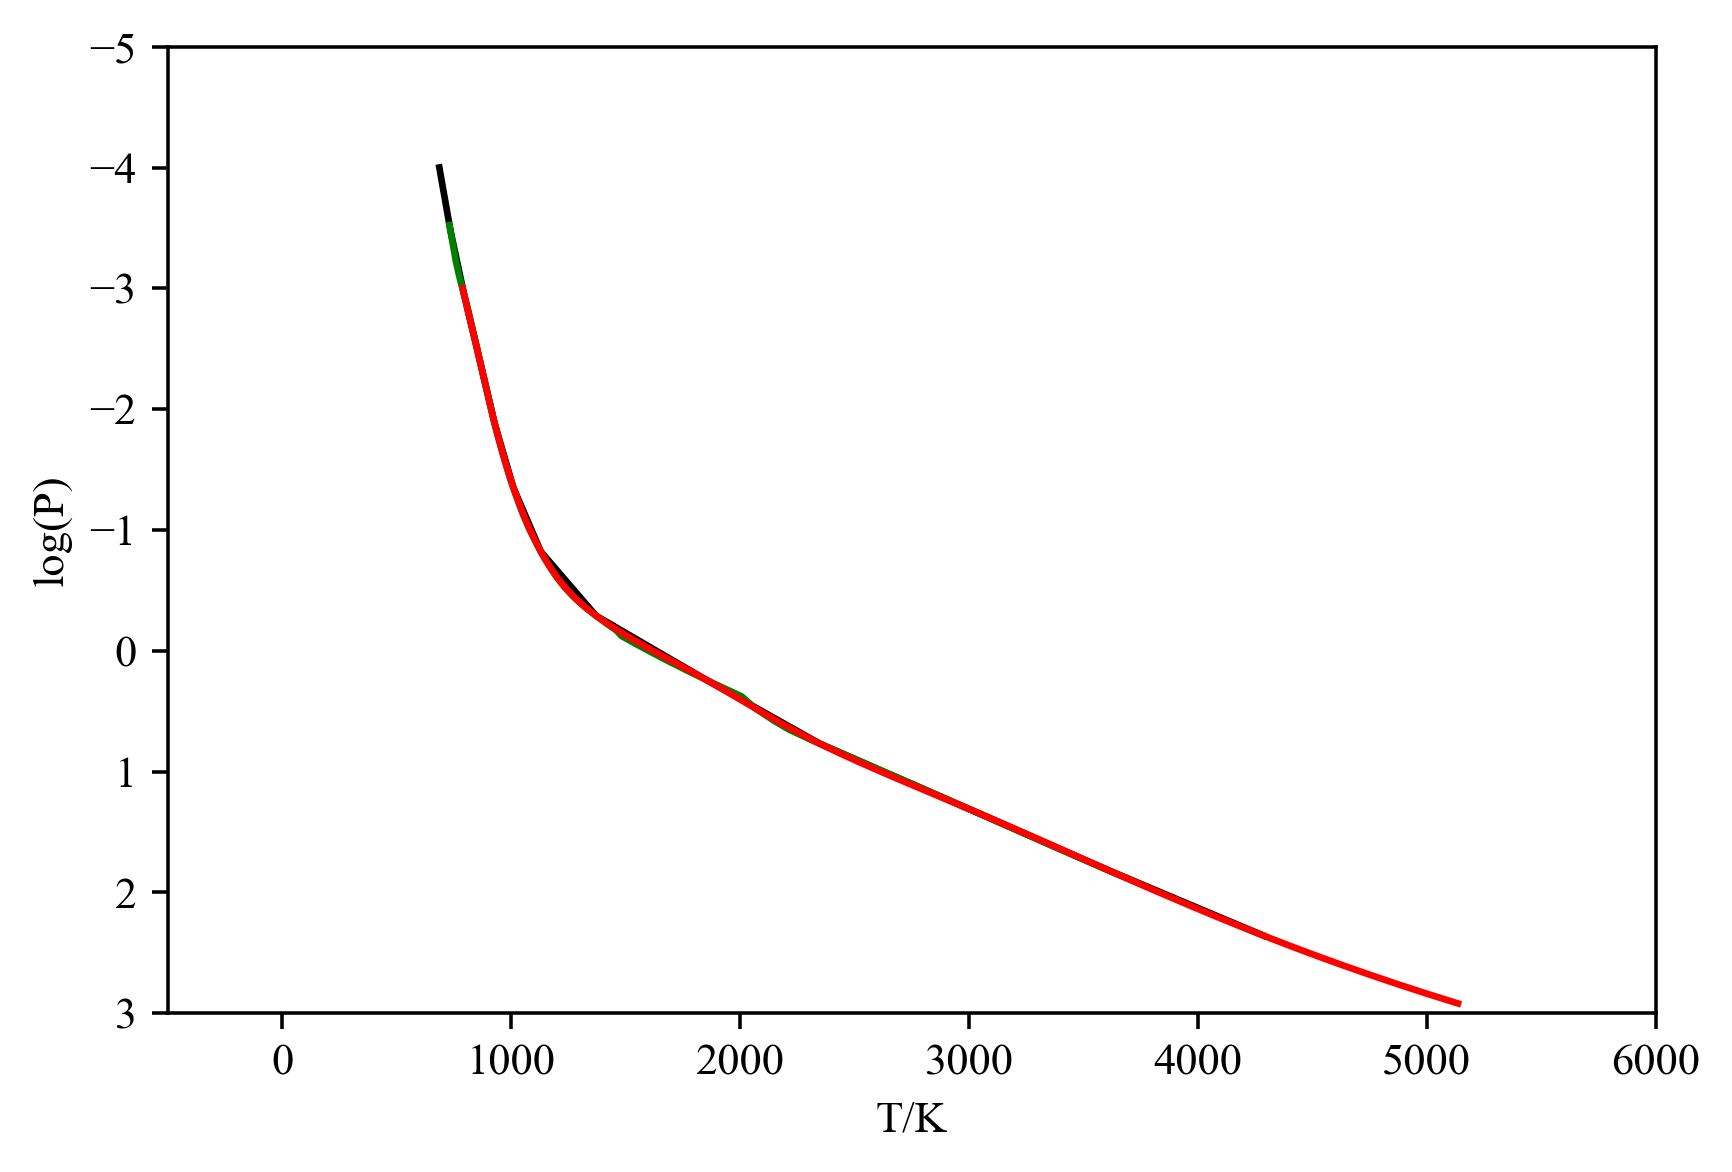

In [20]:
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([-500., 6000.,3.0,-5.0])
plt.plot(prof,logcoarsePress,'k-')
plt.plot(modT,np.log10(modP),'g-')
logP = np.log10(press)
plotT = TPmod.set_prof(proftype,coarsePress,press,prof)
plt.plot(plotT,logP, "r-")

plt.ylabel(r'log(P)')
plt.xlabel('T/K')


In [21]:
LP = testkit.lnprob(theta,*runargs) #* -2. / (obspec.shape[1] /3.)
#print testkit.lnprob(theta2,*runargs) * -2. / (obspec.shape[1] /3.)
print LP

4363.75882201


In [ ]:
#len(pickle.dumps([theta,runargs], -1)) / 1e9

In [20]:
#for gas in range (0,ngas):
##    test= pickle.load( open(lists[gas], "rb" ) )[3]
#    test[np.isnan(test)] = 1.0
#    print test[np.where(np.less(test,0))]
print forwardmodel.marv.__doc__

outspec,phot_press,tau_spec = marv(temp,logg,r2d2,ingasnum,logvmr,pcover,do_clouds,incloudnum,cloudrad,cloudsig,cloudprof,inlinetemps,inpress,inwavenum,inlinelist,cia,ciatemps,use_disort,make_pspec,make_tspec,do_bff,bff)

Wrapper for ``marv``.

Parameters
----------
temp : in/output rank-1 array('d') with bounds (f2py_temp_d0)
logg : input float
r2d2 : input float
ingasnum : in/output rank-1 array('i') with bounds (f2py_ingasnum_d0)
logvmr : in/output rank-2 array('d') with bounds (f2py_logvmr_d0,f2py_logvmr_d1)
pcover : in/output rank-1 array('f') with bounds (f2py_pcover_d0)
do_clouds : in/output rank-1 array('i') with bounds (f2py_do_clouds_d0)
incloudnum : in/output rank-2 array('i') with bounds (f2py_incloudnum_d0,f2py_incloudnum_d1)
cloudrad : in/output rank-3 array('d') with bounds (f2py_cloudrad_d0,f2py_cloudrad_d1,f2py_cloudrad_d2)
cloudsig : in/output rank-3 array('d') with bounds (f2py_cloudsig_d0,f2py_cloudsig_d1,f2py_cloudsig_d2)
cloudprof : in/output rank-3 array('d') wit

In [ ]:
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([-8., 2.,3.0,-5.0])
logP = np.log10(press)
plt.plot(np.log10(cloudprof[0,:,0]),logP, "r-")

plt.ylabel(r'log(P)')
plt.xlabel('log10(dtau)')

In [ ]:
import forwardmodel
print forwardmodel.marv.__doc__